# HOMEWORK PART 2a

---

Download the accompanying ZIP file which includes MATLAB code for solving (i) A reaction-diffusion system of equations, and (ii) The Kuramoto-Sivashinsky (KS) equation.
1. Train a NN that can advance the solution from t to t + ∆t for the KS equation
2. Compare your evolution trajectories for your NN against using the ODE time-stepper provided with
different initial conditions
3. For the reaction-diffusion system, first project to a low-dimensional subspace via the SVD and see how forecasting works in the low-rank variables.

The Kuramoto-Sivashinsky equation represents a pattern forming system with spatio-temporal chaotic behavior. In one dimension we can write the equation as:

\begin{align}
u_t &= -uu_x - u_{xx} - u_{xxxx} \quad \& \quad \textit{periodic BCs}
\end{align}

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split

import torch
import torch.utils.data as Data
torch.manual_seed(113)    # reproducible results
np.random.seed(113)
seed = 113

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42

In [2]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device)

In [3]:
#http://www.databookuw.com/page-17/
#https://people.maths.ox.ac.uk/trefethen/pdectb/kuramoto2.pdf

# Modification  nplt = np.floor((tmax / 250) / h) with nplt = 32, in this way
# The number of samples in time does not depend on the final time

def KS(length, x_dim, final_t):
    """Kuramoto-Sivashinsky equation solver parametrized on the interval length"""
    N = x_dim
    x = length * np.pi * np.arange(1, N + 1) / N
    u = np.cos(x / 16) * (1 + np.sin(x / 16)) # initial function
    v = np.fft.fft(u)

    #Spatial grid and initial condition:
    h = 0.025
    k = np.concatenate([np.arange(0, N / 2), [0], np.arange(-N / 2 + 1, 0)]) / 16
    L = k ** 2 - k ** 4
    E, E2 = np.exp(h * L), np.exp(h * L / 2)
    M = 16
    r = np.exp(1j * np.pi * (np.arange(1, M + 1) - .5) / M)
    LR = h * np.tile(L, (M, 1)).T + np.tile(r, (N, 1))
    Q = h * np.real(np.mean((np.exp(LR / 2) - 1) / LR, axis=1))
    f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3 * LR + LR ** 2)) / LR ** 3, axis=1))
    f2 = h * np.real(np.mean((2 + LR + np.exp(LR) * (-2 + LR)) / LR ** 3, axis=1))
    f3 = h * np.real(np.mean((-4 - 3 * LR - LR ** 2 + np.exp(LR) * (4 - LR)) / LR ** 3, axis=1))

    # Main time-stepping loop:
    uu = u
    tt = 0
    tmax = final_t
    nmax = round(tmax / h) 
    #nplt = np.floor((tmax / 250) / h) 
    nplt = 32
    g = -0.5j * k;
    for n in range(1, nmax + 1):
        t = n * h
        Nv = g * np.fft.fft(np.real(np.fft.ifft(v)) ** 2)
        a = E2 * v + Q * Nv
        Na = g * np.fft.fft(np.real(np.fft.ifft(a)) ** 2)
        b = E2 * v + Q * Na
        Nb = g * np.fft.fft(np.real(np.fft.ifft(b)) ** 2)
        c = E2 * a + Q * (2 * Nb - Nv);
        Nc = g * np.fft.fft(np.real(np.fft.ifft(c)) ** 2)
        v = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3 
        if np.mod(n, nplt) == 0:
            u = np.real(np.fft.ifft(v))
            uu = np.vstack([uu, u]) 
            tt = np.append(tt, t)
    return x, uu, tt

Personalized cmap

In [4]:
#colors = [(0, 0, 0), (0.5, 0.5, 0.5), (1, 1, 1), (0.1, 0.9, 1), (0.12, 0.56, 1)]
colors = [(0, 0, 0), (0.5, 0.5, 0.5), (1, 1, 1), (1, 0.4, 0.4), (1, 0., 0.)]
cmap_name = 'dark_blue'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=100)

## Point 1: Train a NN that can advance the solution from t to t + ∆t for the KS equation.

In [78]:
L = 32
n_x = 128
x, u, t = KS(L, n_x, 100)
n_t = len(t)
t_max = t[-1]

X = u[:-1, :]
y = u[1:, :]

<IPython.core.display.Javascript object>


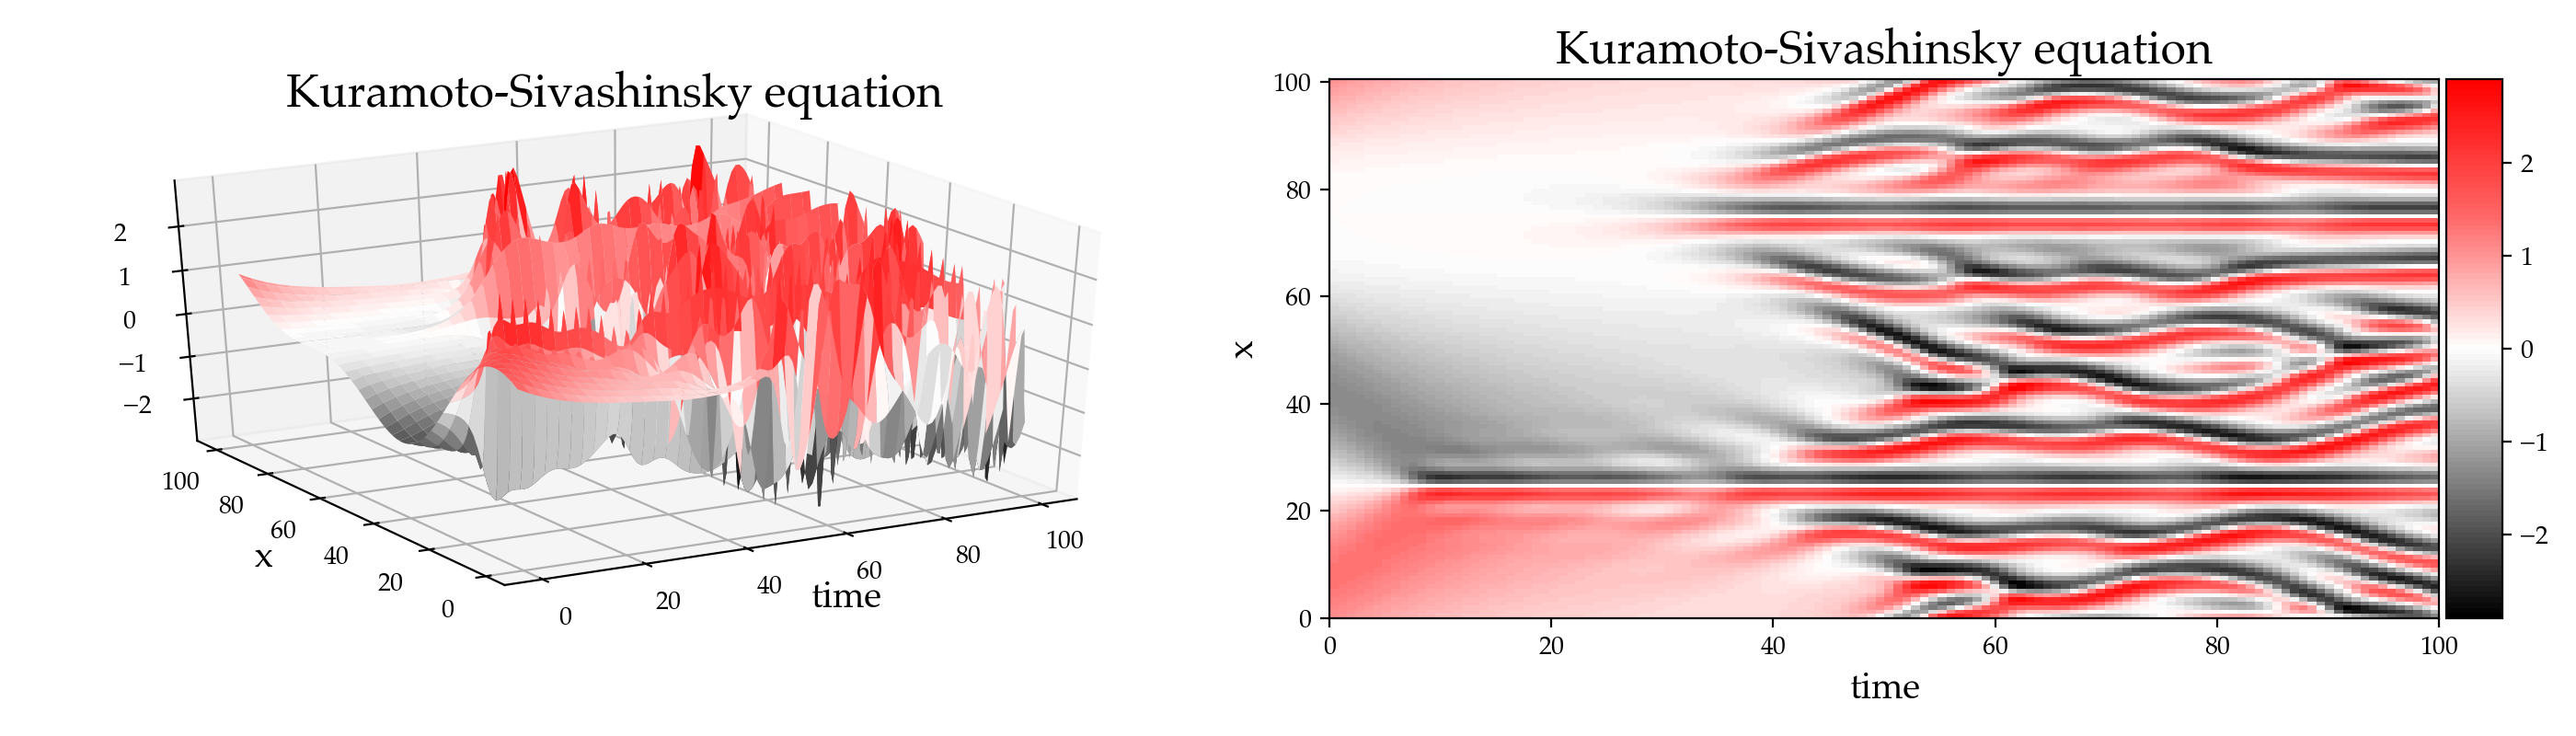

In [29]:
fig = plt.figure(figsize=(14, 4))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
ax = plt.subplot(gs[0, 0], projection='3d')
T, XX = np.meshgrid(t, x)
h = ax.plot_surface(T, XX, u.T, cmap=cm)
ax.view_init(elev=30., azim=-120)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Kuramoto-Sivashinsky equation', fontsize = 18)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u.T, interpolation='nearest', cmap=cm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Kuramoto-Sivashinsky equation', fontsize = 18)

gs.tight_layout(fig)

Train / test split

In [30]:
X_train, _X_tmp, y_train, _y_tmp = train_test_split(X, y, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(_X_tmp, _y_tmp, test_size=0.5, random_state=seed+1)

Network architecture

In [31]:
class MLPNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MLPNN, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        h_relu = self.linear2(h_relu).clamp(min=0)
        h_relu = self.linear3(h_relu).clamp(min=0)
        y_pred = self.linear4(h_relu)
        return y_pred

In [32]:
batch = 16

train_dataset = Data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = Data.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = Data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch, shuffle=False)
val_loader = Data.DataLoader(dataset=val_dataset, batch_size=X_val.shape[0], shuffle=False)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=X_test.shape[0], shuffle=False)

Let's train the network for different values of the number of neurons

In [67]:
D_in, H, D_out = n_x, int(n_x / 2), n_x

epochs = 1000

model1 = MLPNN(D_in, H, D_out)

criterion = torch.nn.MSELoss(reduction='sum') 
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-4)
train_loss = []
for epoch in range(epochs):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        y_pred = model1(batch_x)
        loss = criterion(y_pred, batch_y)
        train_loss.append(loss.item())
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print("Iteration: ", epoch, " Loss: ", loss.item())

Iteration:  0  Loss:  459.30902099609375
Iteration:  100  Loss:  19.451173782348633
Iteration:  200  Loss:  9.13731575012207
Iteration:  300  Loss:  6.075715065002441
Iteration:  400  Loss:  3.5849649906158447
Iteration:  500  Loss:  3.09914493560791
Iteration:  600  Loss:  2.62931227684021
Iteration:  700  Loss:  2.242767333984375
Iteration:  800  Loss:  1.999243974685669
Iteration:  900  Loss:  1.8975391387939453


In [68]:
D_in, H, D_out = n_x, int(n_x), n_x

epochs = 1000

model2 = MLPNN(D_in, H, D_out)

criterion = torch.nn.MSELoss(reduction='sum') 
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-4)
train_loss = []
for epoch in range(epochs):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        y_pred = model2(batch_x)
        loss = criterion(y_pred, batch_y)
        train_loss.append(loss.item())
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print("Iteration: ", epoch, " Loss: ", loss.item())

Iteration:  0  Loss:  456.8480224609375
Iteration:  100  Loss:  12.286198616027832
Iteration:  200  Loss:  4.2167277336120605
Iteration:  300  Loss:  2.6340019702911377
Iteration:  400  Loss:  2.22868013381958
Iteration:  500  Loss:  1.844383716583252
Iteration:  600  Loss:  1.6337370872497559
Iteration:  700  Loss:  1.520249843597412
Iteration:  800  Loss:  1.2528960704803467
Iteration:  900  Loss:  1.1752665042877197


In [69]:
D_in, H, D_out = n_x, int(2 * n_x), n_x

epochs = 1000

model3 = MLPNN(D_in, H, D_out)

criterion = torch.nn.MSELoss(reduction='sum') 
optimizer = torch.optim.SGD(model3.parameters(), lr=1e-4)
train_loss = []
for epoch in range(epochs):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        y_pred = model3(batch_x)
        loss = criterion(y_pred, batch_y)
        train_loss.append(loss.item())
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print("Iteration: ", epoch, " Loss: ", loss.item())

Iteration:  0  Loss:  437.5448913574219
Iteration:  100  Loss:  7.862558364868164
Iteration:  200  Loss:  2.8927407264709473
Iteration:  300  Loss:  1.8845231533050537
Iteration:  400  Loss:  1.4974102973937988
Iteration:  500  Loss:  1.2324739694595337
Iteration:  600  Loss:  1.0386335849761963
Iteration:  700  Loss:  0.8690168261528015
Iteration:  800  Loss:  0.7605527639389038
Iteration:  900  Loss:  0.6261887550354004


In [70]:
D_in, H, D_out = n_x, int(3 * n_x), n_x

epochs = 1000

model4 = MLPNN(D_in, H, D_out)

criterion = torch.nn.MSELoss(reduction='sum') 
optimizer = torch.optim.SGD(model4.parameters(), lr=1e-4)
train_loss = []
for epoch in range(epochs):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        y_pred = model4(batch_x)
        loss = criterion(y_pred, batch_y)
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print("Iteration: ", epoch, " Loss: ", loss.item())

Iteration:  0  Loss:  420.16546630859375
Iteration:  100  Loss:  5.306240558624268
Iteration:  200  Loss:  2.1706786155700684
Iteration:  300  Loss:  1.6085950136184692
Iteration:  400  Loss:  1.284776210784912
Iteration:  500  Loss:  1.0382463932037354
Iteration:  600  Loss:  0.863530695438385
Iteration:  700  Loss:  0.7356125712394714
Iteration:  800  Loss:  0.620768666267395
Iteration:  900  Loss:  0.5229703187942505


In [71]:
check_test = False

with torch.no_grad():
    for step, (batch_x, batch_y) in enumerate(val_loader):
        y_pred1 = model1(batch_x)
        y_pred2 = model2(batch_x)
        y_pred3 = model3(batch_x)
        y_pred4 = model4(batch_x)
        loss_val1 = criterion(y_pred1, batch_y)
        loss_val2 = criterion(y_pred2, batch_y)
        loss_val3 = criterion(y_pred3, batch_y)
        loss_val4 = criterion(y_pred4, batch_y)
print("Model 1, Validation Loss: ", loss_val1.item() / len(batch_x))
print("Model 2, Validation Loss: ", loss_val2.item() / len(batch_x))
print("Model 3, Validation Loss: ", loss_val3.item() / len(batch_x))
print("Model 4, Validation Loss: ", loss_val4.item() / len(batch_x))

if check_test:
    with torch.no_grad():
          for step, (batch_x, batch_y) in enumerate(test_loader):
                y_pred = model(batch_x)
                loss_test = criterion(y_pred, batch_y)
    print(loss_test / len(batch_x))

Model 1, Validation Loss:  0.9677017529805502
Model 2, Validation Loss:  0.5540127754211426
Model 3, Validation Loss:  0.4350705146789551
Model 4, Validation Loss:  0.3729094664255778


In [79]:
# Free time marching
u1f, u2f, u3f, u4f = np.empty((n_t, n_x)), np.empty((n_t, n_x)), np.empty((n_t, n_x)), np.empty((n_t, n_x))

u1f[0, :], u2f[0, :], u3f[0, :], u4f[0, :] = X[0, :], X[0, :], X[0, :], X[0, :]
for i in range(n_t-1):
    with torch.no_grad():
        u1f[i+1, :] = model1(torch.from_numpy(u1f[i, :]).squeeze(0).float())
        u2f[i+1, :] = model2(torch.from_numpy(u2f[i, :]).squeeze(0).float())
        u3f[i+1, :] = model3(torch.from_numpy(u3f[i, :]).squeeze(0).float())
        u4f[i+1, :] = model4(torch.from_numpy(u4f[i, :]).squeeze(0).float())

In [80]:
# Guided time marching
tensor_X = torch.from_numpy(X).float()
with torch.no_grad():
    prediction1 = model1(tensor_X)
    prediction2 = model2(tensor_X)
    prediction3 = model3(tensor_X)
    prediction4 = model4(tensor_X)

u1g = np.vstack((tensor_X[0, :], prediction1))
u2g = np.vstack((tensor_X[0, :], prediction2))
u3g = np.vstack((tensor_X[0, :], prediction3))
u4g = np.vstack((tensor_X[0, :], prediction4))

In [81]:
t_train = t[X_train.shape[0]]

<IPython.core.display.Javascript object>


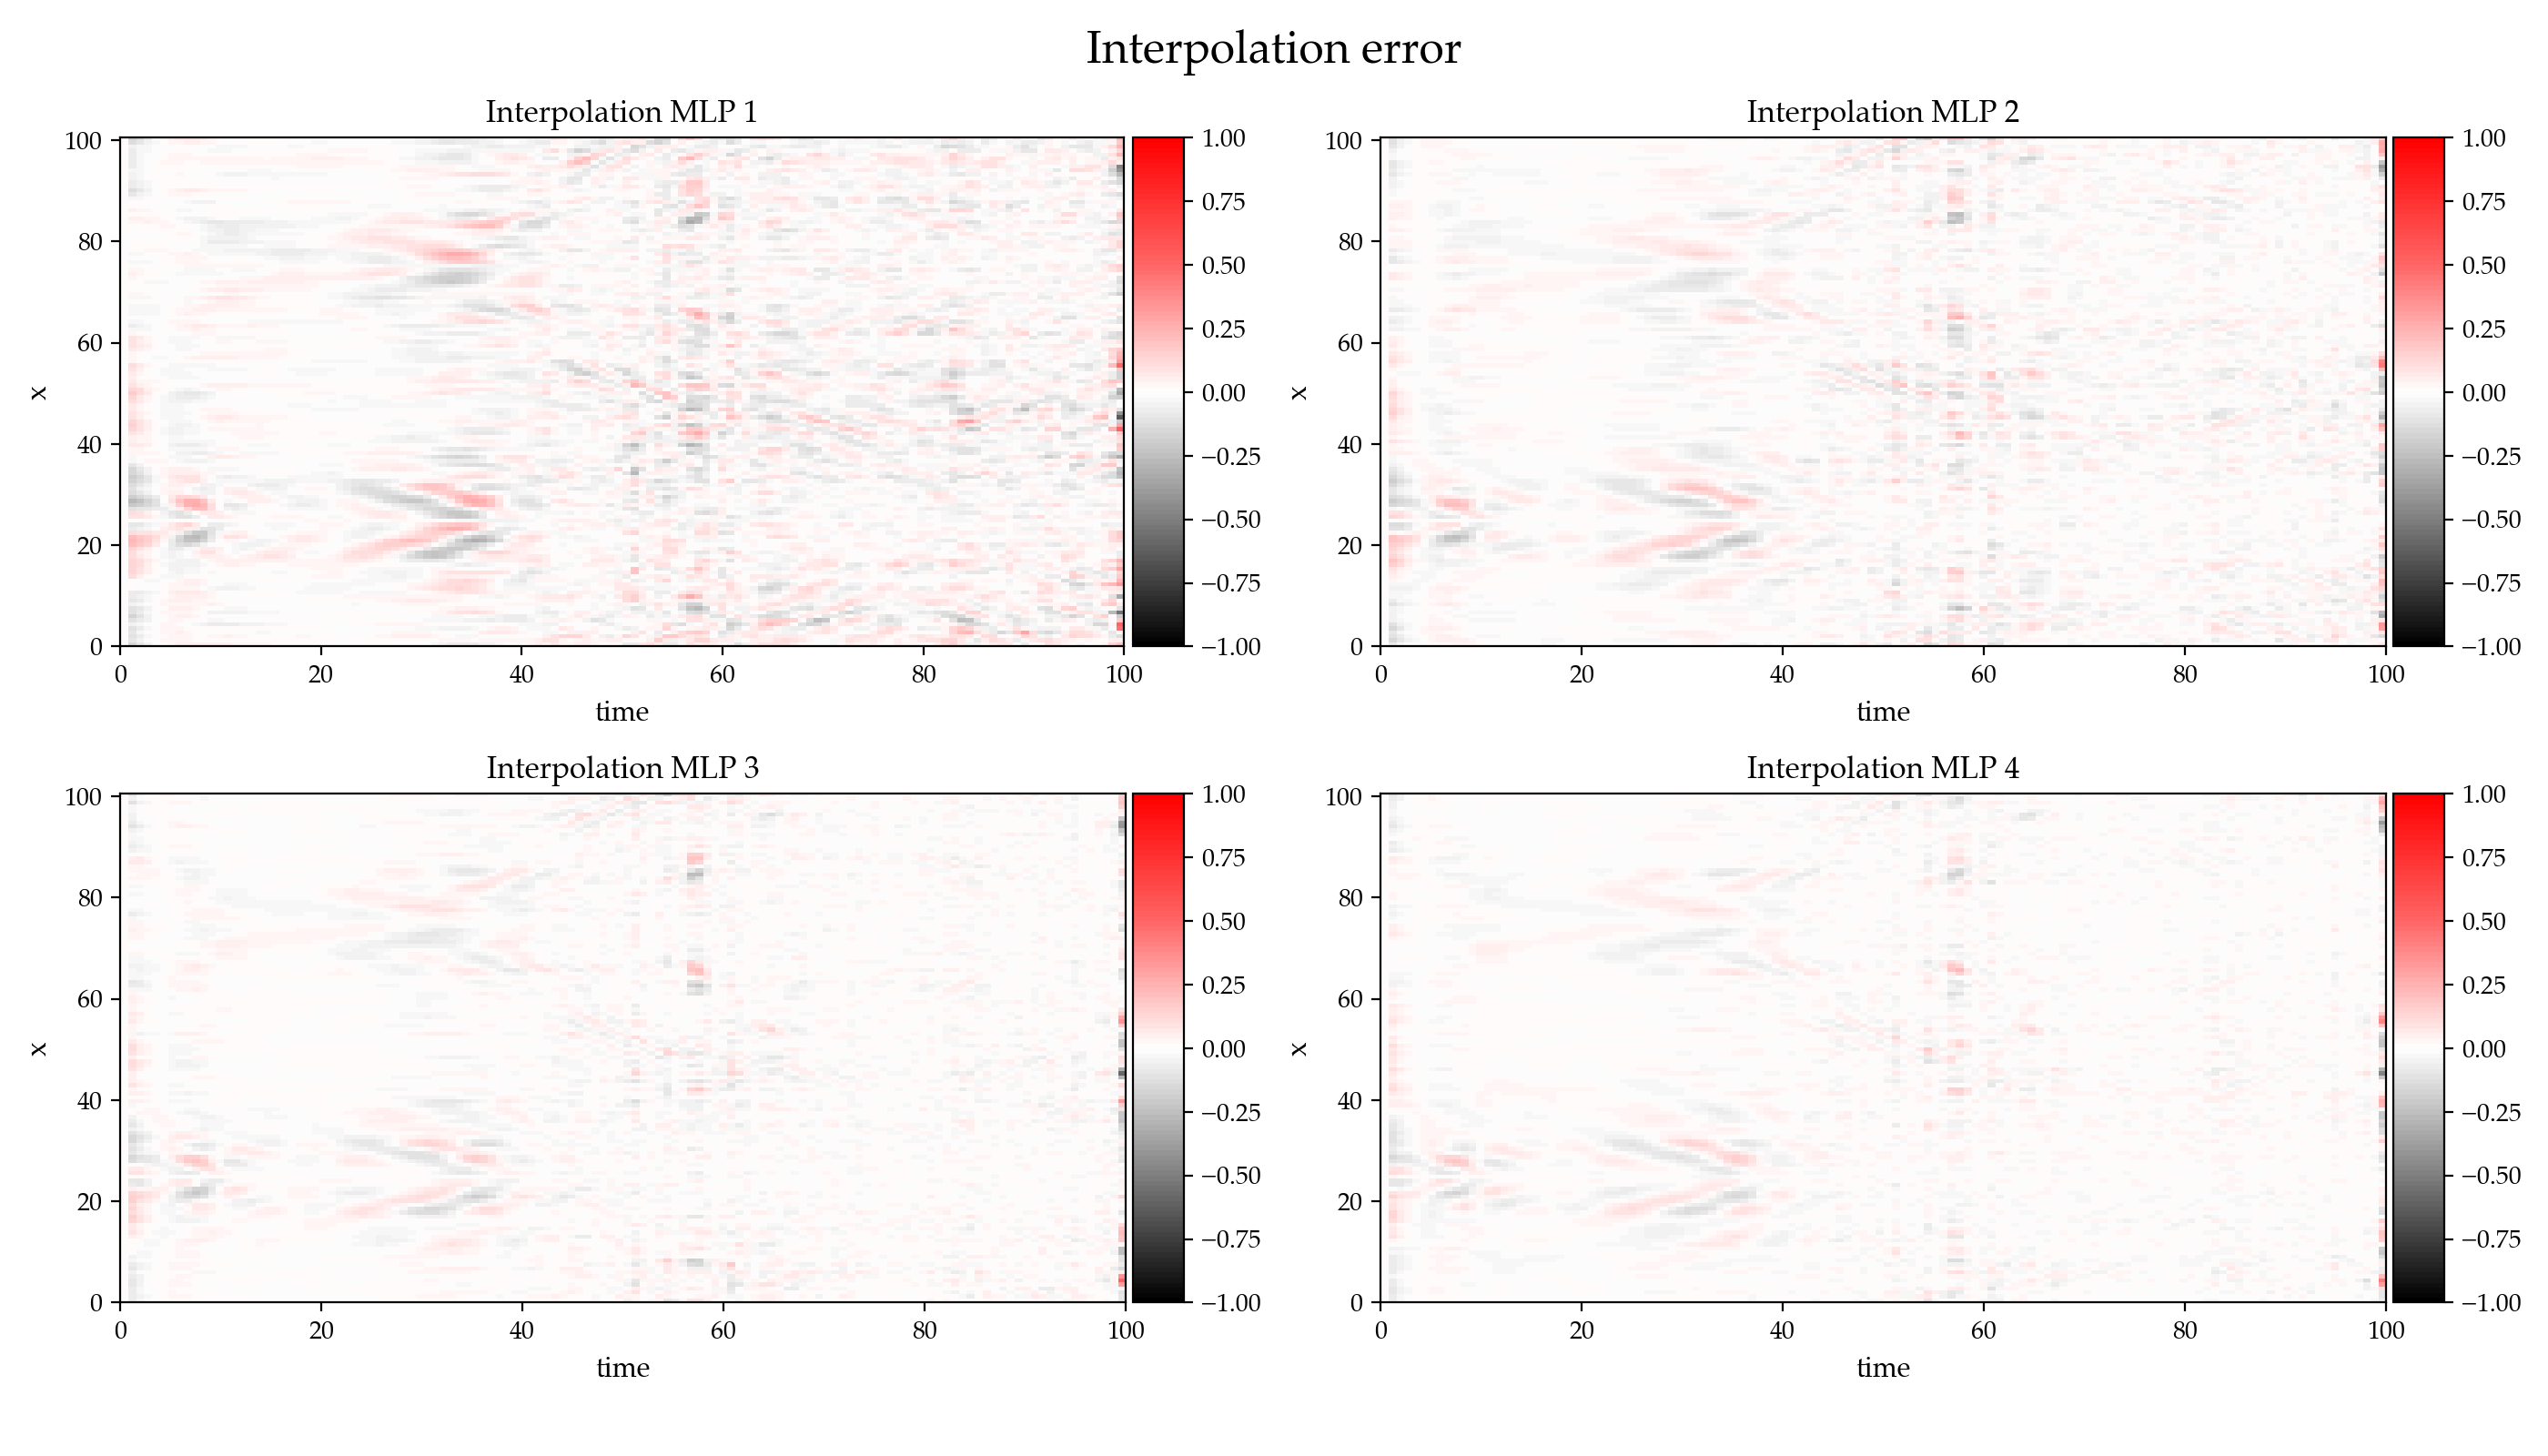

In [82]:
fig = plt.figure(figsize=(14, 8))
fig.suptitle("Interpolation error", fontsize=18)

norm = mpl.colors.Normalize(vmin=-1, vmax=1)

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
ax = plt.subplot(gs[0, 0])
h = ax.imshow(u1g.T-u.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Interpolation MLP 1', fontsize = 12)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u2g.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Interpolation MLP 2', fontsize = 12)

ax = plt.subplot(gs[1, 0])
h = ax.imshow(u3g.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Interpolation MLP 3', fontsize = 12)

ax = plt.subplot(gs[1, 1])
h = ax.imshow(u4g.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Interpolation MLP 4', fontsize = 12)

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/interp_err.pdf', format='pdf', dpi=1200)

<IPython.core.display.Javascript object>


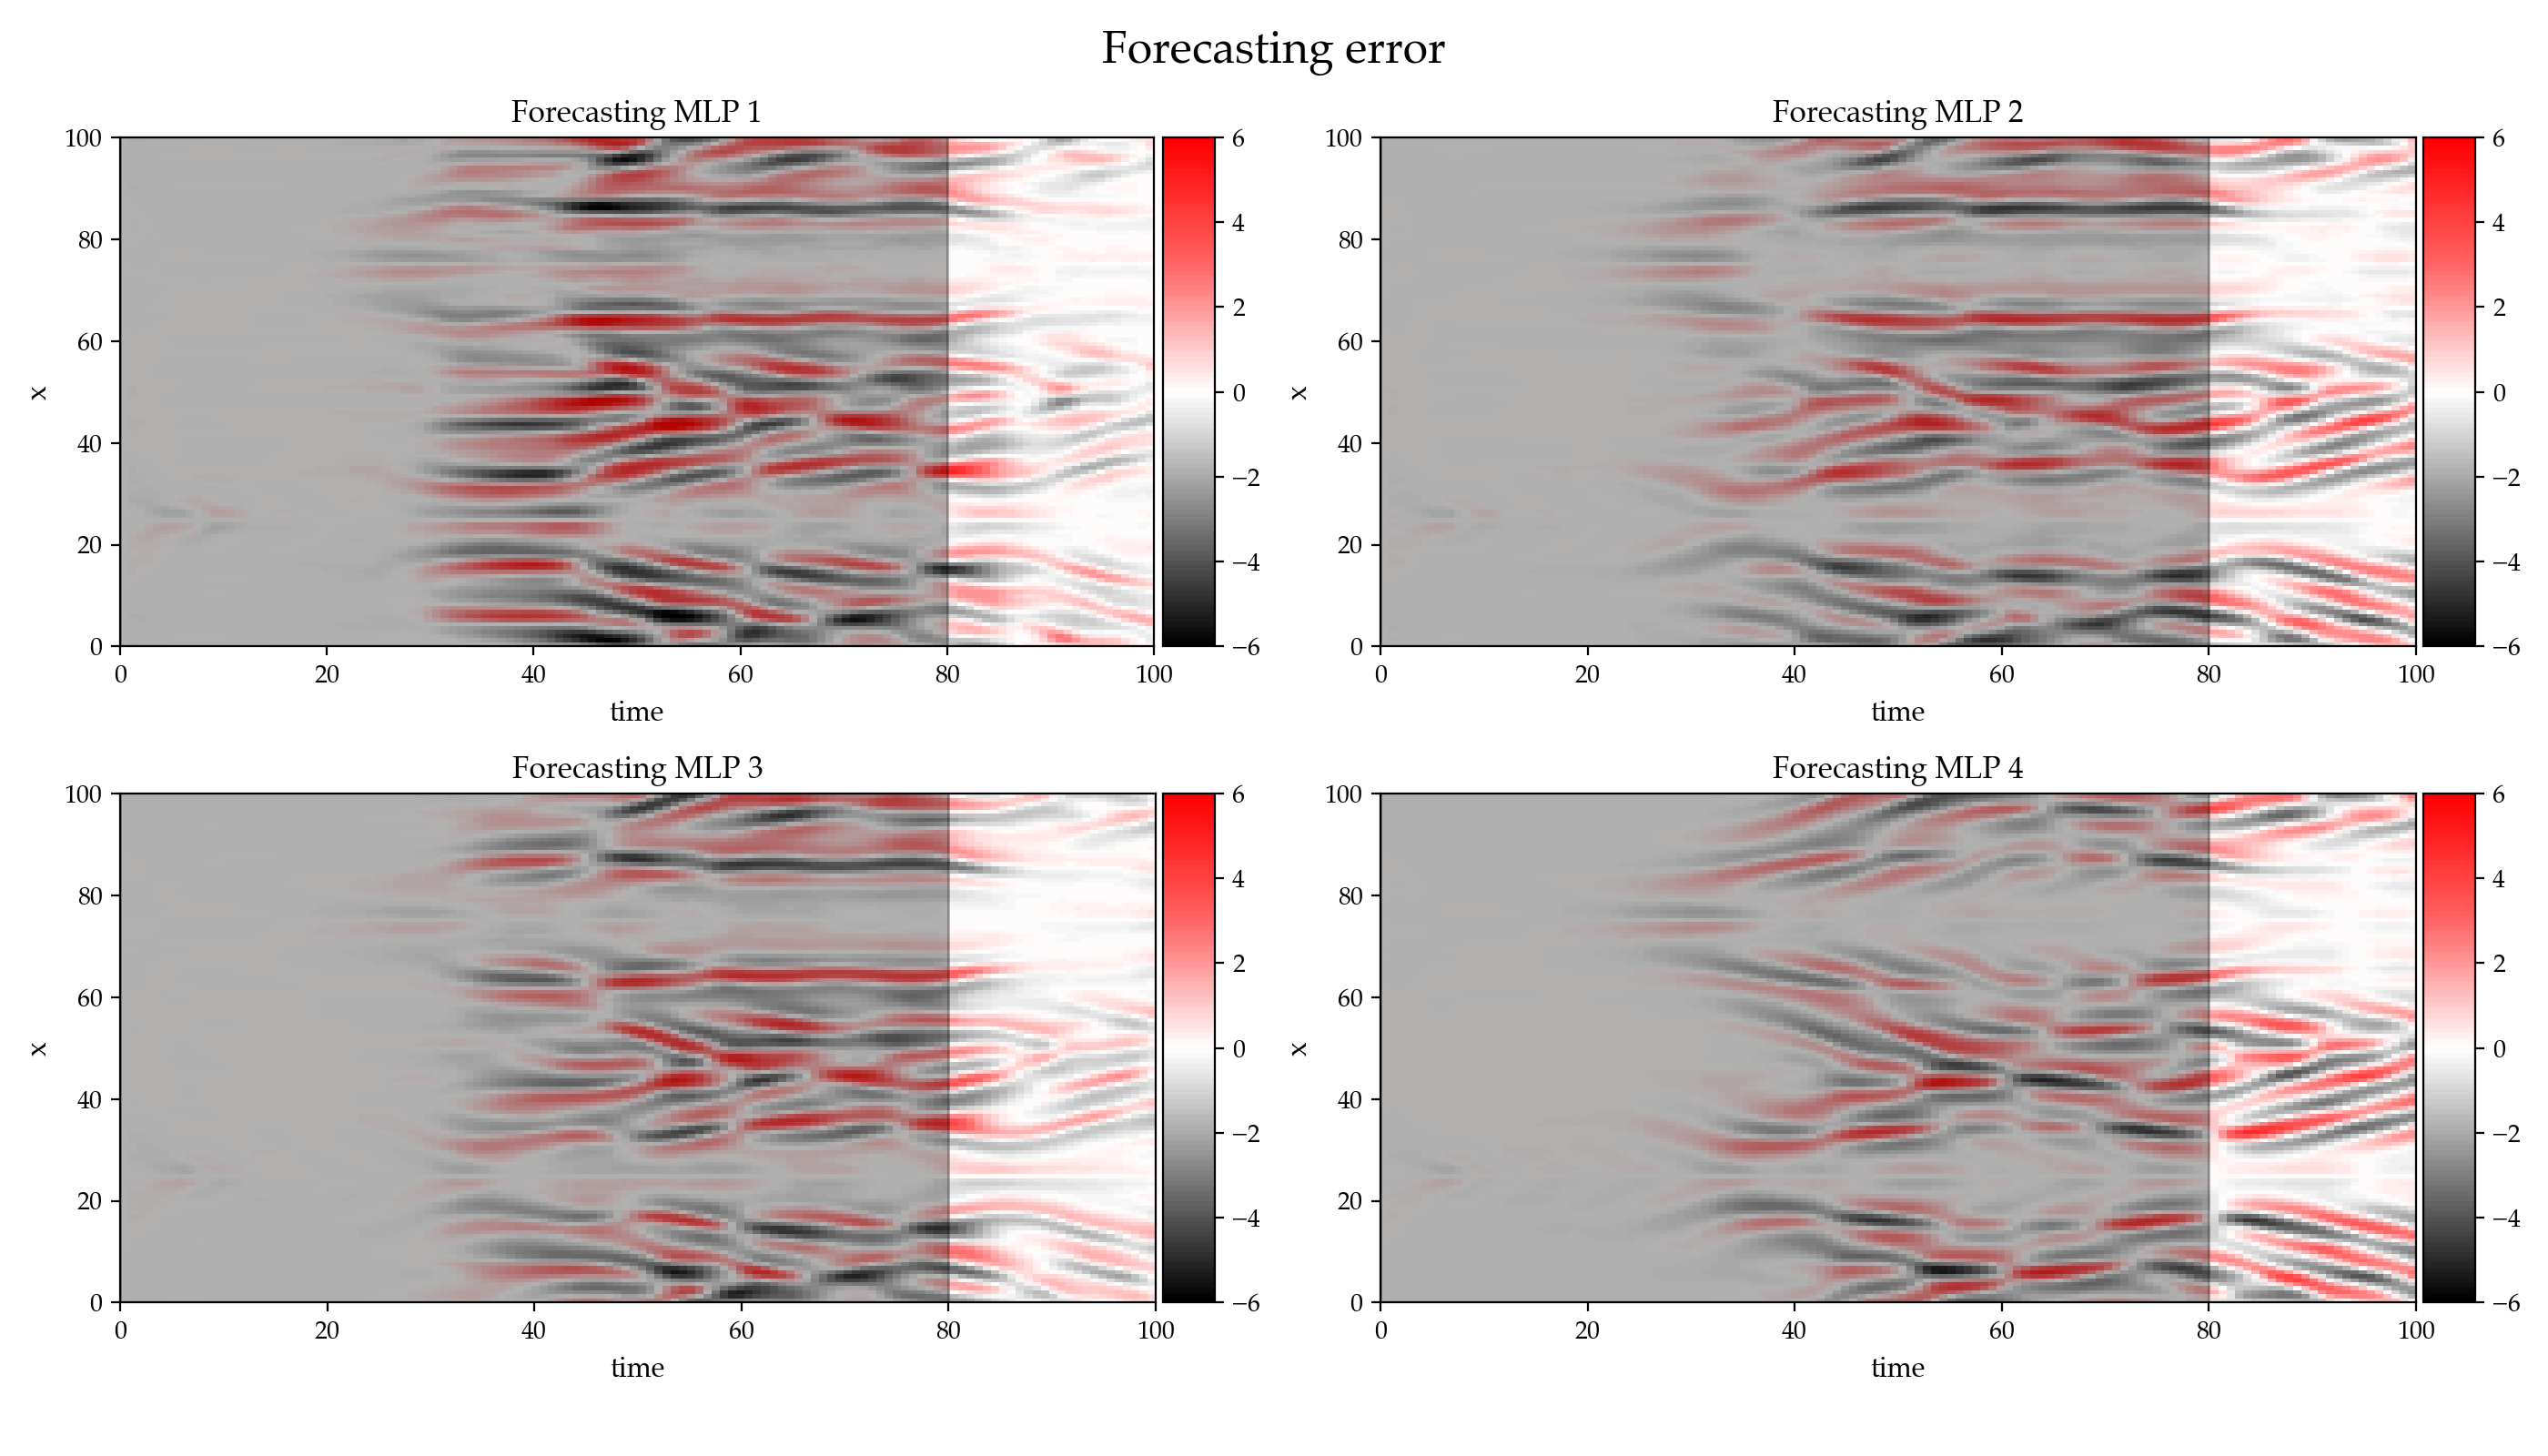

In [83]:
fig = plt.figure(figsize=(14, 8))
fig.suptitle("Forecasting error", fontsize=18)

norm = mpl.colors.Normalize(vmin=-6, vmax=6)

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
ax = plt.subplot(gs[0, 0])
h = ax.imshow(u1f.T-u.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')

ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.3)
ax.set_ylim([0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP 1', fontsize = 12)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u2f.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.3)
ax.set_ylim([0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP 2', fontsize = 12)

ax = plt.subplot(gs[1, 0])
h = ax.imshow(u3f.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.3)
ax.set_ylim([0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP 3', fontsize = 12)

ax = plt.subplot(gs[1, 1])
h = ax.imshow(u4f.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.3)
ax.set_ylim([0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP 4', fontsize = 12)

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/fore_err.pdf', format='pdf', dpi=1200)

<IPython.core.display.Javascript object>


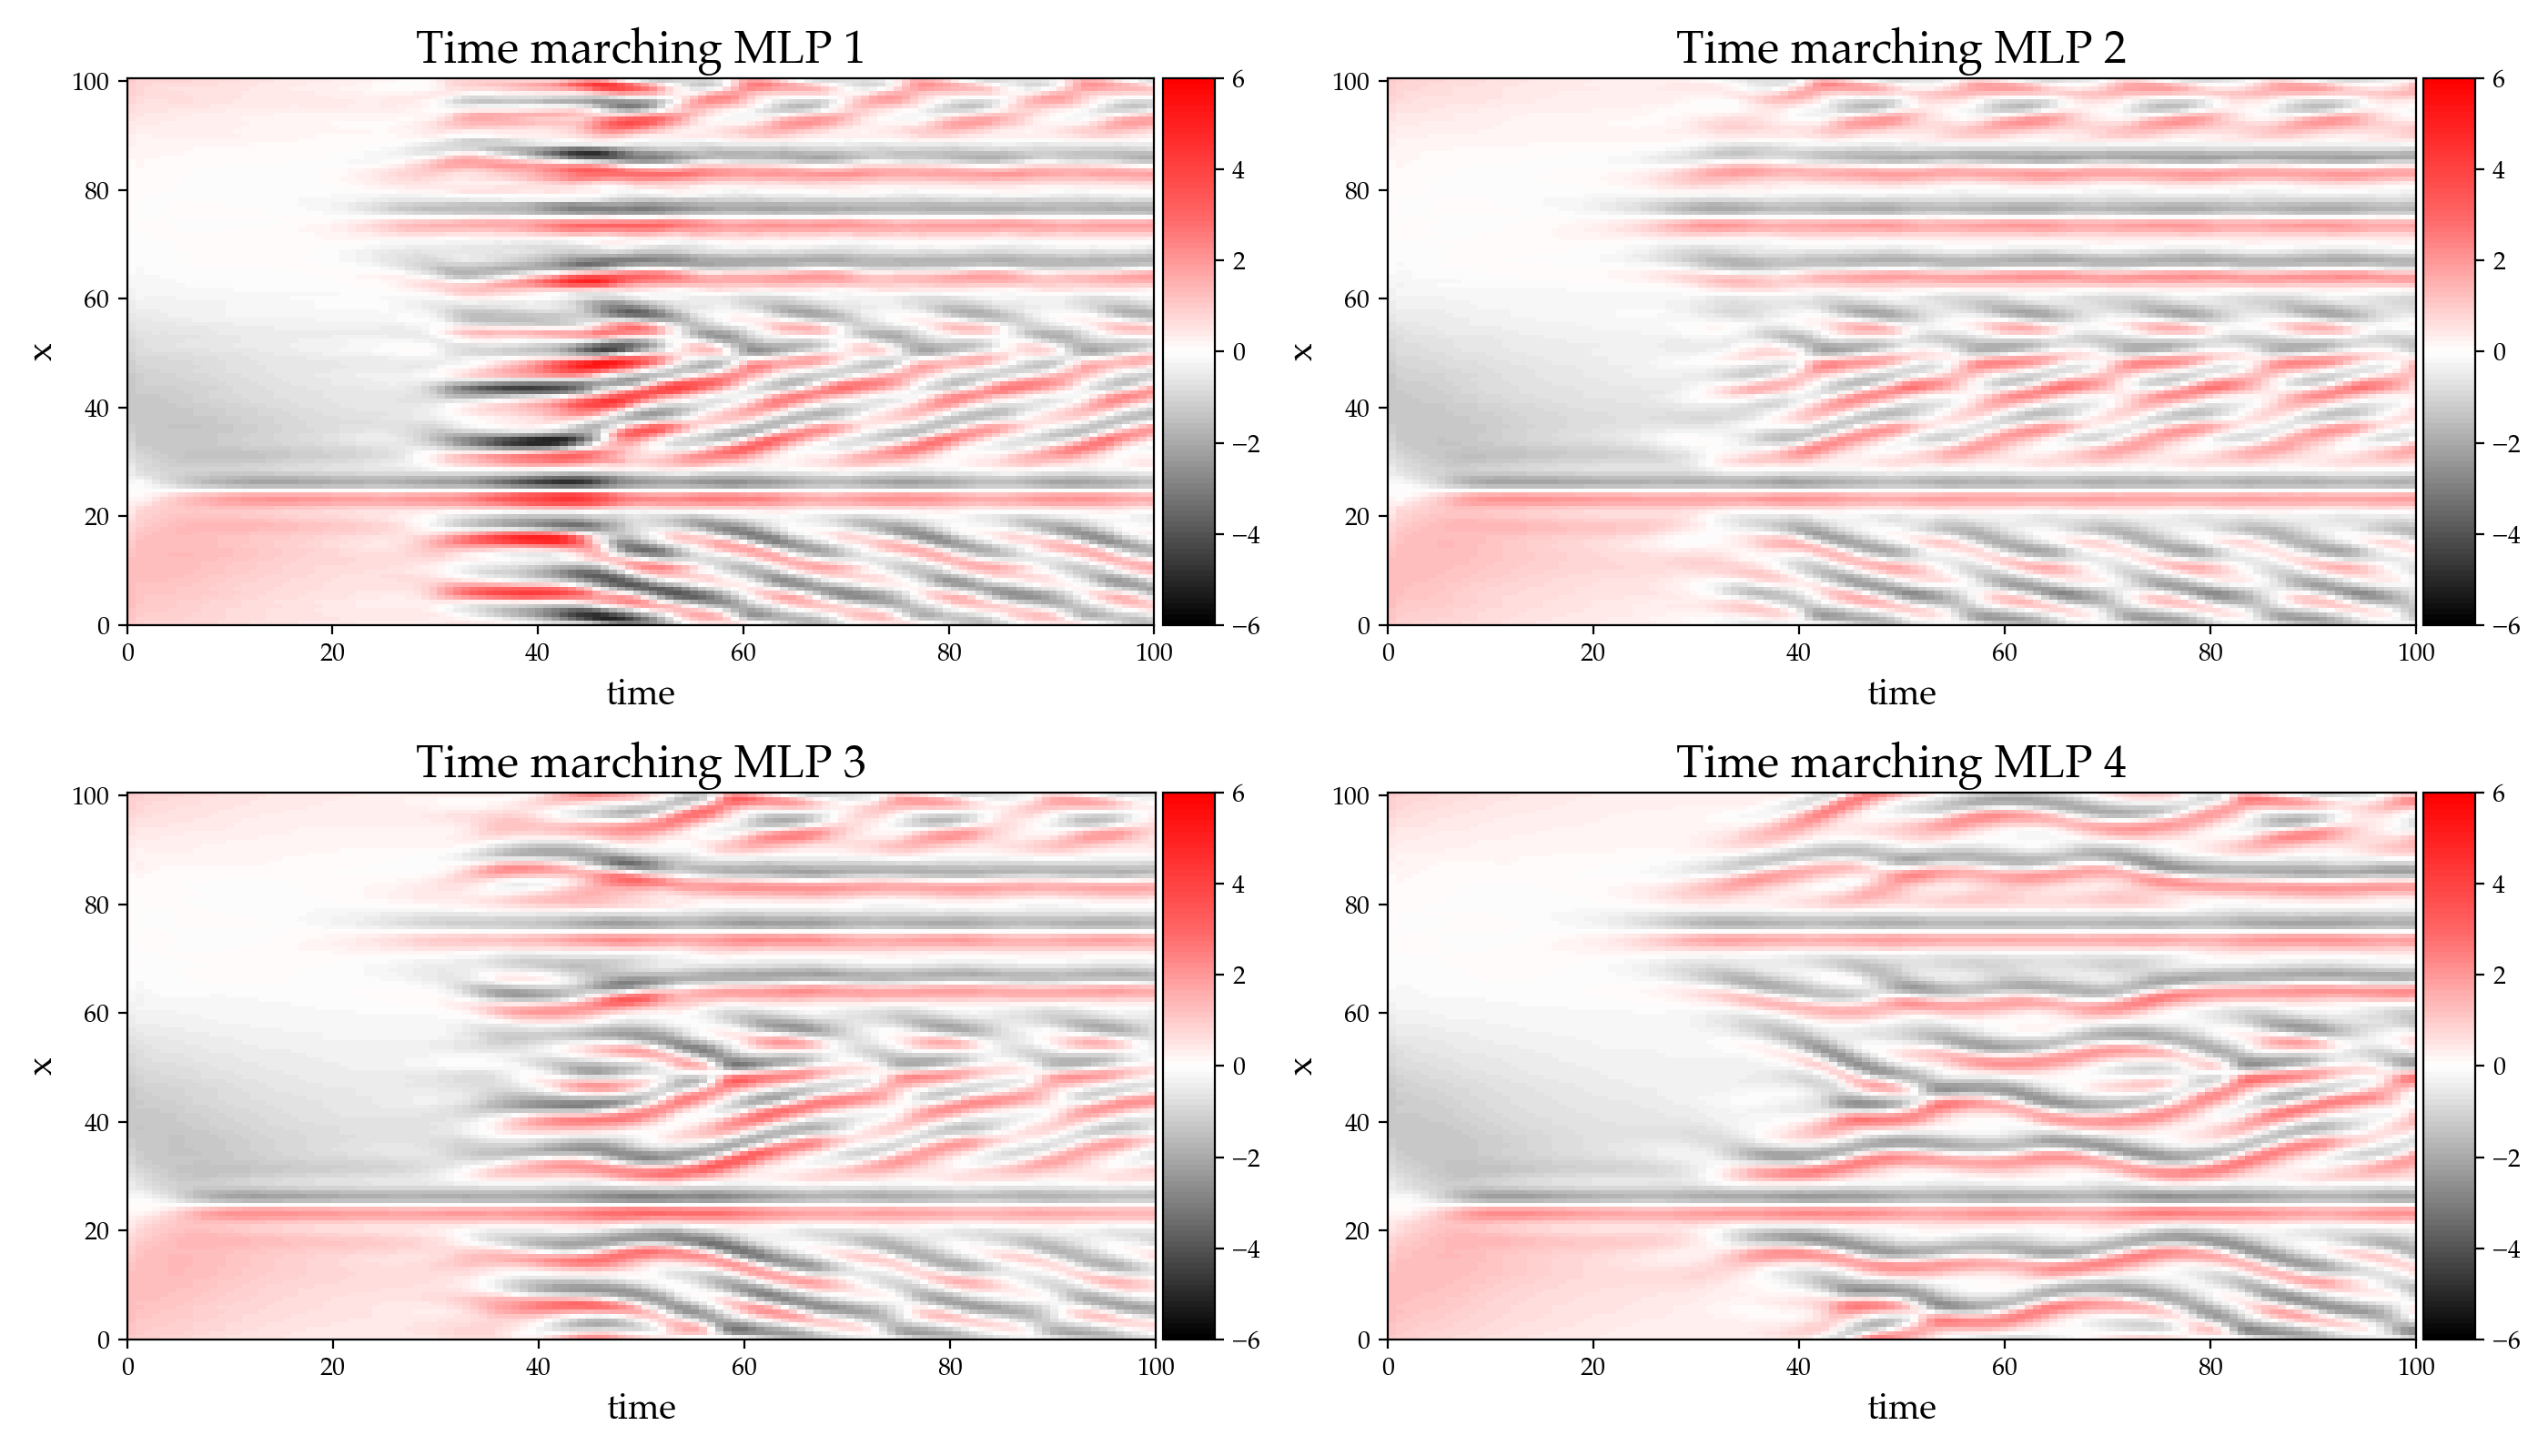

In [84]:
fig = plt.figure(figsize=(14, 8))

norm = mpl.colors.Normalize(vmin=-6, vmax=6)

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
ax = plt.subplot(gs[0, 0])
h = ax.imshow(u1f.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Time marching MLP 1', fontsize = 18)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u2f.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Time marching MLP 2', fontsize = 18)

ax = plt.subplot(gs[1, 0])
h = ax.imshow(u3f.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Time marching MLP 3', fontsize = 18)

ax = plt.subplot(gs[1, 1])
h = ax.imshow(u4f.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Time marching MLP 4', fontsize = 18)

gs.tight_layout(fig)

fig.savefig('figures/time_marching.pdf', format='pdf', dpi=1200)

In [85]:
from sklearn.metrics import r2_score
global_err1 = np.mean((u - u1f) ** 2)
global_err2 = np.mean((u - u2f) ** 2)
global_err3 = np.mean((u - u3f) ** 2)
global_err4 = np.mean((u - u4f) ** 2)

print('- - - - -')
print("Model 1, error: ", global_err1)
print('- - - - -')
print('\n')
print('- - - - -')
print("Model 2, error: ", global_err2)
print('- - - - -')
print('\n')
print('- - - - -')
print("Model 3, error: ", global_err3)
print('- - - - -')
print('\n')
print('- - - - -')
print("Model 4, error: ", global_err4)
print('- - - - -')

- - - - -
Model 1, error:  1.6523165772754924
- - - - -


- - - - -
Model 2, error:  1.2933333093888966
- - - - -


- - - - -
Model 3, error:  1.182057515596687
- - - - -


- - - - -
Model 4, error:  1.1611752195760245
- - - - -


Forecast the system state for 200 s

In [103]:
L = 32
t_max = 200
x_f, u_f, t_f = KS(L, n_x, t_max)
n_t = len(t_f)

# Free time marching
u_frc = np.empty((n_t, n_x))
u_frc[0, :] = u_f[0, :]
for i in range(n_t-1):
    with torch.no_grad():
        u_frc[i+1, :] = model4(torch.from_numpy(u_frc[i, :]).squeeze(0).float())

<IPython.core.display.Javascript object>


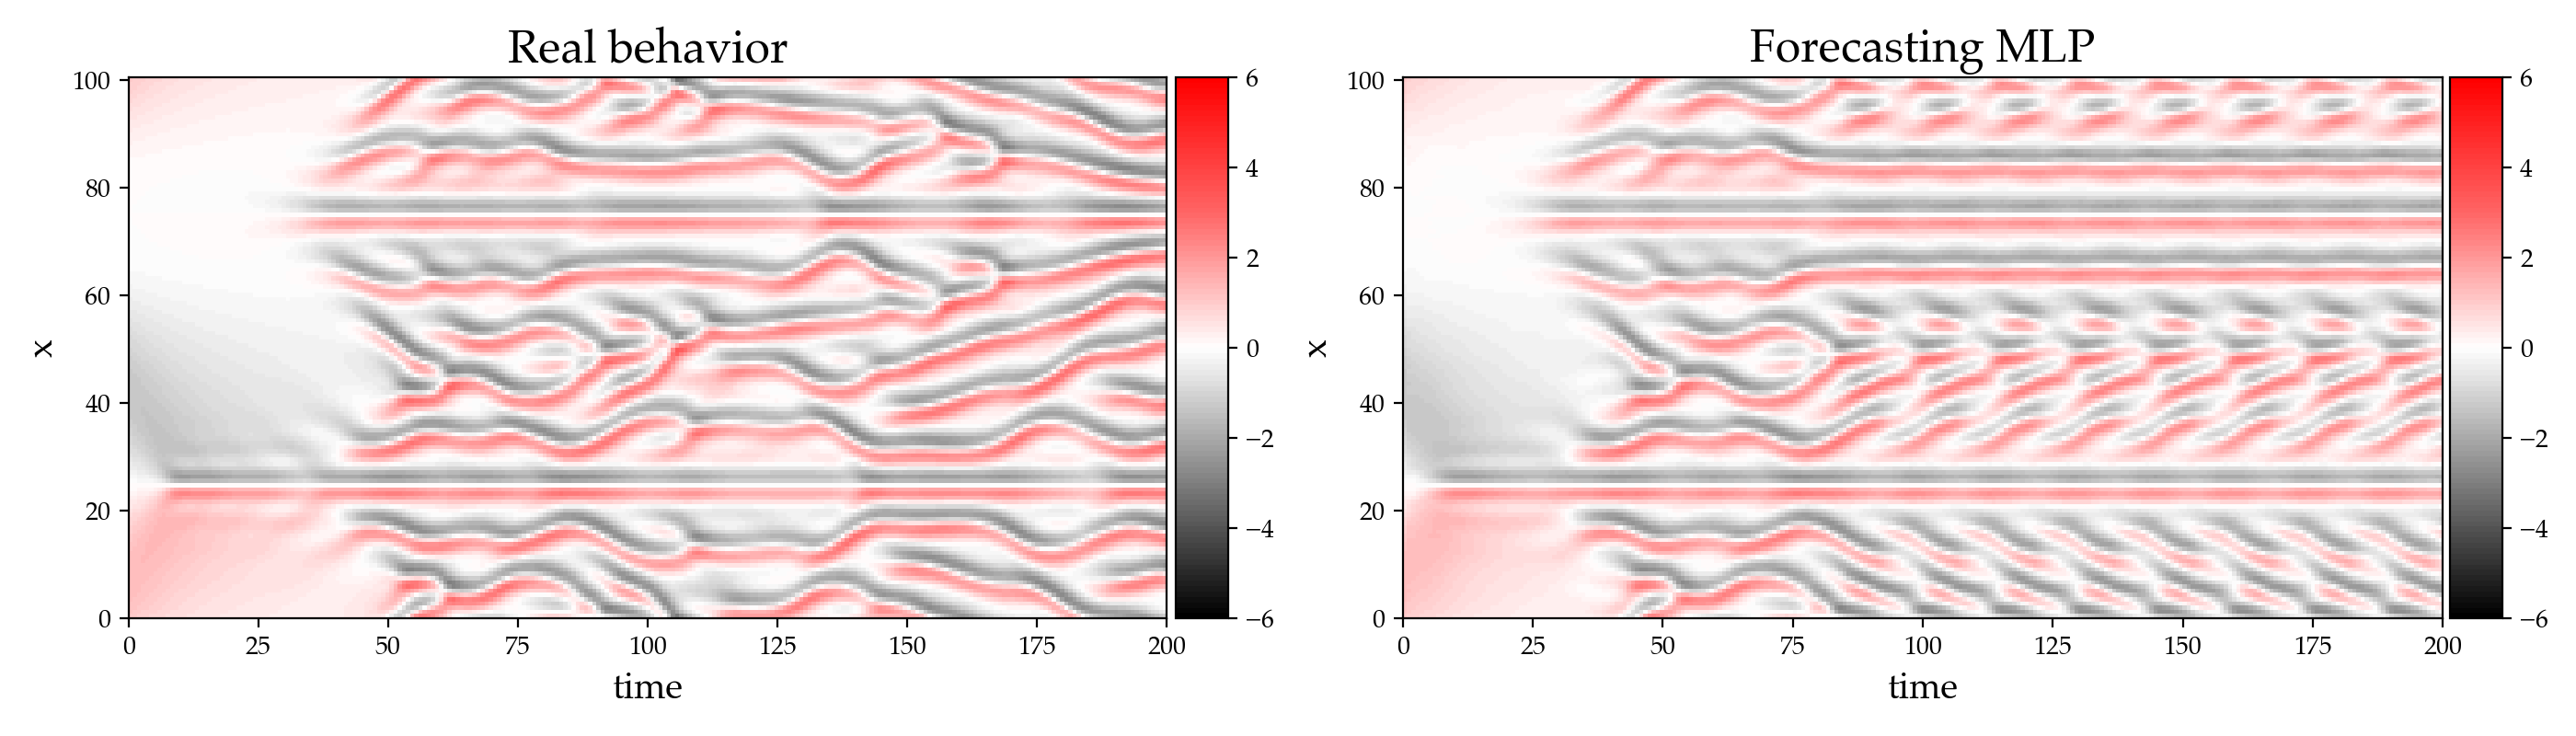

In [104]:
fig = plt.figure(figsize=(14, 4))

norm = mpl.colors.Normalize(vmin=-6, vmax=6)

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.imshow(u_f.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Real behavior', fontsize = 18)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u_frc.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Forecasting MLP', fontsize = 18)

gs.tight_layout(fig)

fig.savefig('figures/fore.pdf', format='pdf', dpi=1200)

In [105]:
L = 34
t_max = 100
x_f, u_f, t_f = KS(L, n_x, t_max)
n_t = len(t_f)

# Free time marching
u_frc = np.empty((n_t, n_x))
u_frc[0, :] = u_f[0, :]
for i in range(n_t-1):
    with torch.no_grad():
        u_frc[i+1, :] = model4(torch.from_numpy(u_frc[i, :]).squeeze(0).float())

<IPython.core.display.Javascript object>


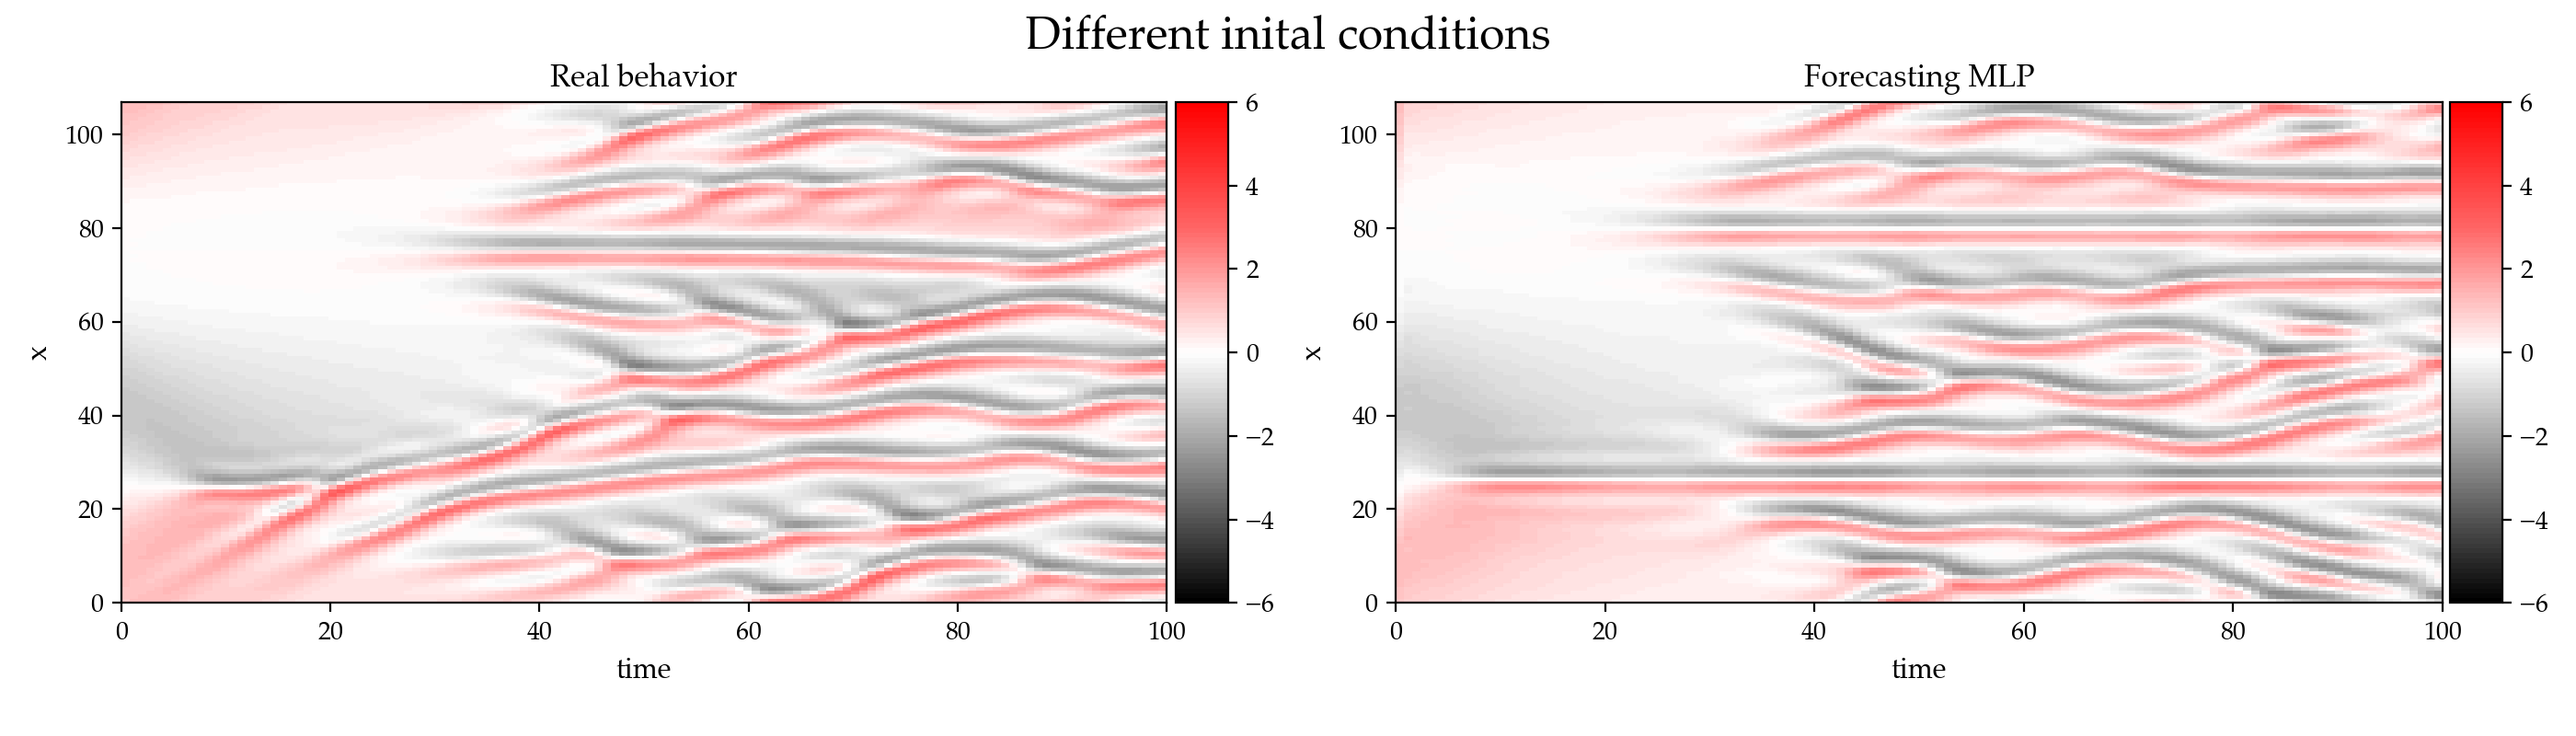

In [106]:
fig = plt.figure(figsize=(14, 4))
fig.suptitle("Different inital conditions", fontsize=18)

norm = mpl.colors.Normalize(vmin=-6, vmax=6)

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.imshow(u_f.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Real behavior', fontsize = 12)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u_frc.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP', fontsize = 12)

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/fore_diff_ic.pdf', format='pdf', dpi=1200)

## Point 2: Compare your evolution trajectories for your NN against using the ODE time-stepper provided with different initial conditions



<IPython.core.display.Javascript object>


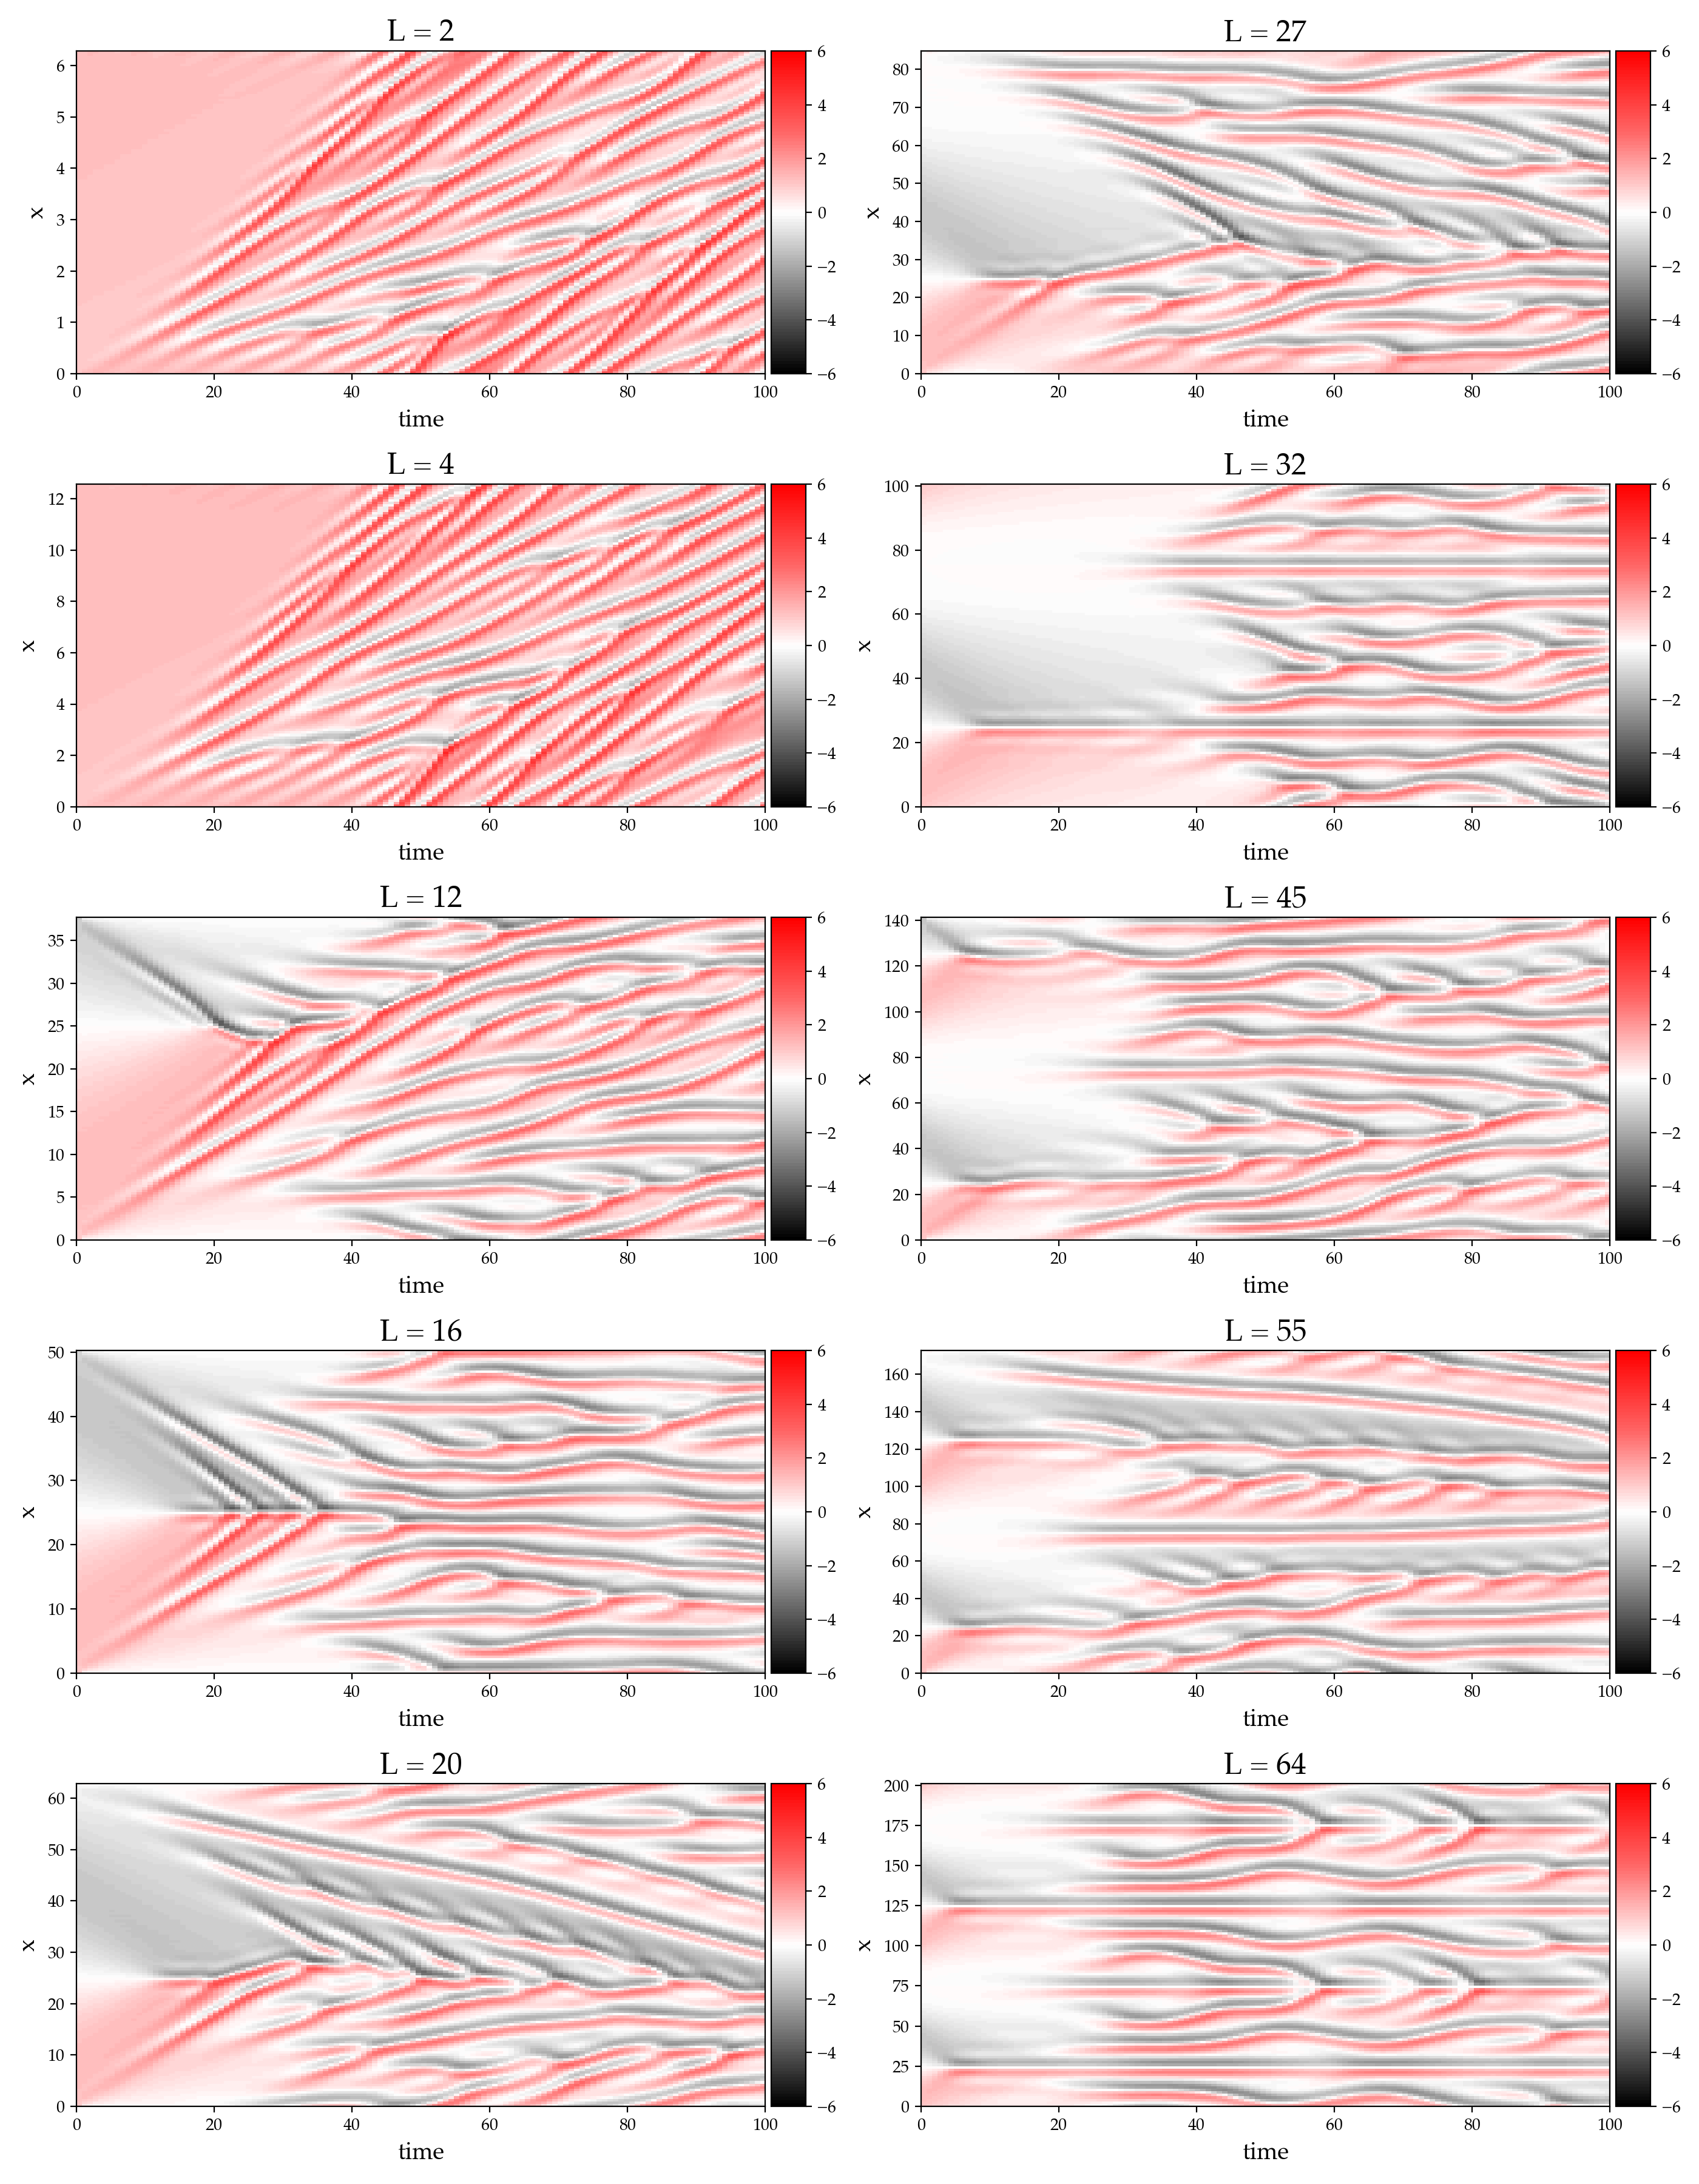

In [107]:
L = [2, 4, 12, 16, 20, 27, 32, 45, 55, 64]
t_max = 100

norm = mpl.colors.Normalize(vmin=-6, vmax=6)

fig = plt.figure(figsize=(14, 18))
gs = gridspec.GridSpec(int(len(L) / 2), 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.5)
col = 0
for i in range(len(L)):
    x, u, t = KS(L[i], n_x, t_max)
    if i == int(len(L) / 2):
        col += 1
    ax = plt.subplot(gs[i%int(len(L) / 2), col])
    h = ax.imshow(u.T, interpolation='nearest', cmap=cm, norm=norm,
                extent=[0, t_max, 0, L[i]*np.pi],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('time', fontsize = 14)
    ax.set_ylabel('x', fontsize = 14)
    ax.set_title('L = %d' % L[i], fontsize = 18)
    
gs.tight_layout(fig)

In [108]:
X_train = None
Y_train = None
t_max = 100
for i in range(len(L)):

    x_f, u_f, t_f = KS(L[i], n_x, t_max)

    _X_f = u_f[:-1, :]
    y_f = u_f[1:, :]
    
    ic = np.ones_like(_X_f[None,:, 0]) * L[i]
    
    X_f = np.hstack((_X_f, ic.T))
    
    X_train = X_f if X_train is None else np.vstack((X_train, X_f)) 
    Y_train = y_f if Y_train is None else np.vstack((Y_train, y_f)) 

In [109]:
batch = 32

train_dataset = Data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch, shuffle=False)

In [124]:
D_in, H, D_out = n_x+1, int(n_x * 3), n_x

epochs = 2000

model_fore = MLPNN(D_in, H, D_out)

criterion = torch.nn.MSELoss(reduction='sum') 
optimizer = torch.optim.Adam(model_fore.parameters(), lr=1e-4)
train_loss = []
for epoch in range(epochs):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        y_pred = model_fore(batch_x)
        loss = criterion(y_pred, batch_y)
        train_loss.append(loss.item())
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print("Iteration: ", epoch, " Loss: ", loss.item())

Iteration:  0  Loss:  313.21112060546875
Iteration:  100  Loss:  18.22126579284668
Iteration:  200  Loss:  13.968491554260254
Iteration:  300  Loss:  8.536684036254883
Iteration:  400  Loss:  4.054839134216309
Iteration:  500  Loss:  3.677544593811035
Iteration:  600  Loss:  4.616152763366699
Iteration:  700  Loss:  3.118490219116211
Iteration:  800  Loss:  2.9970133304595947
Iteration:  900  Loss:  2.6280951499938965
Iteration:  1000  Loss:  1.8447743654251099
Iteration:  1100  Loss:  1.5356135368347168
Iteration:  1200  Loss:  1.164023995399475
Iteration:  1300  Loss:  1.2155916690826416
Iteration:  1400  Loss:  1.0816502571105957
Iteration:  1500  Loss:  1.5224361419677734
Iteration:  1600  Loss:  0.7860170006752014
Iteration:  1700  Loss:  1.0313762426376343
Iteration:  1800  Loss:  1.0761449337005615
Iteration:  1900  Loss:  1.0145829916000366


In [129]:
L = 16
t_max = 100
x_f, u_f, t_f = KS(L, n_x, t_max)
n_t = len(t_f)

# Free time marching
u_frc = np.empty((n_t, n_x+1))
u_frc[0, :-1] = u_f[0, :]
u_frc[:, -1] = L
for i in range(n_t-1):
    with torch.no_grad():
        u_frc[i+1, :-1] = model_fore(torch.from_numpy(u_frc[i, :]).squeeze(0).float())

<IPython.core.display.Javascript object>


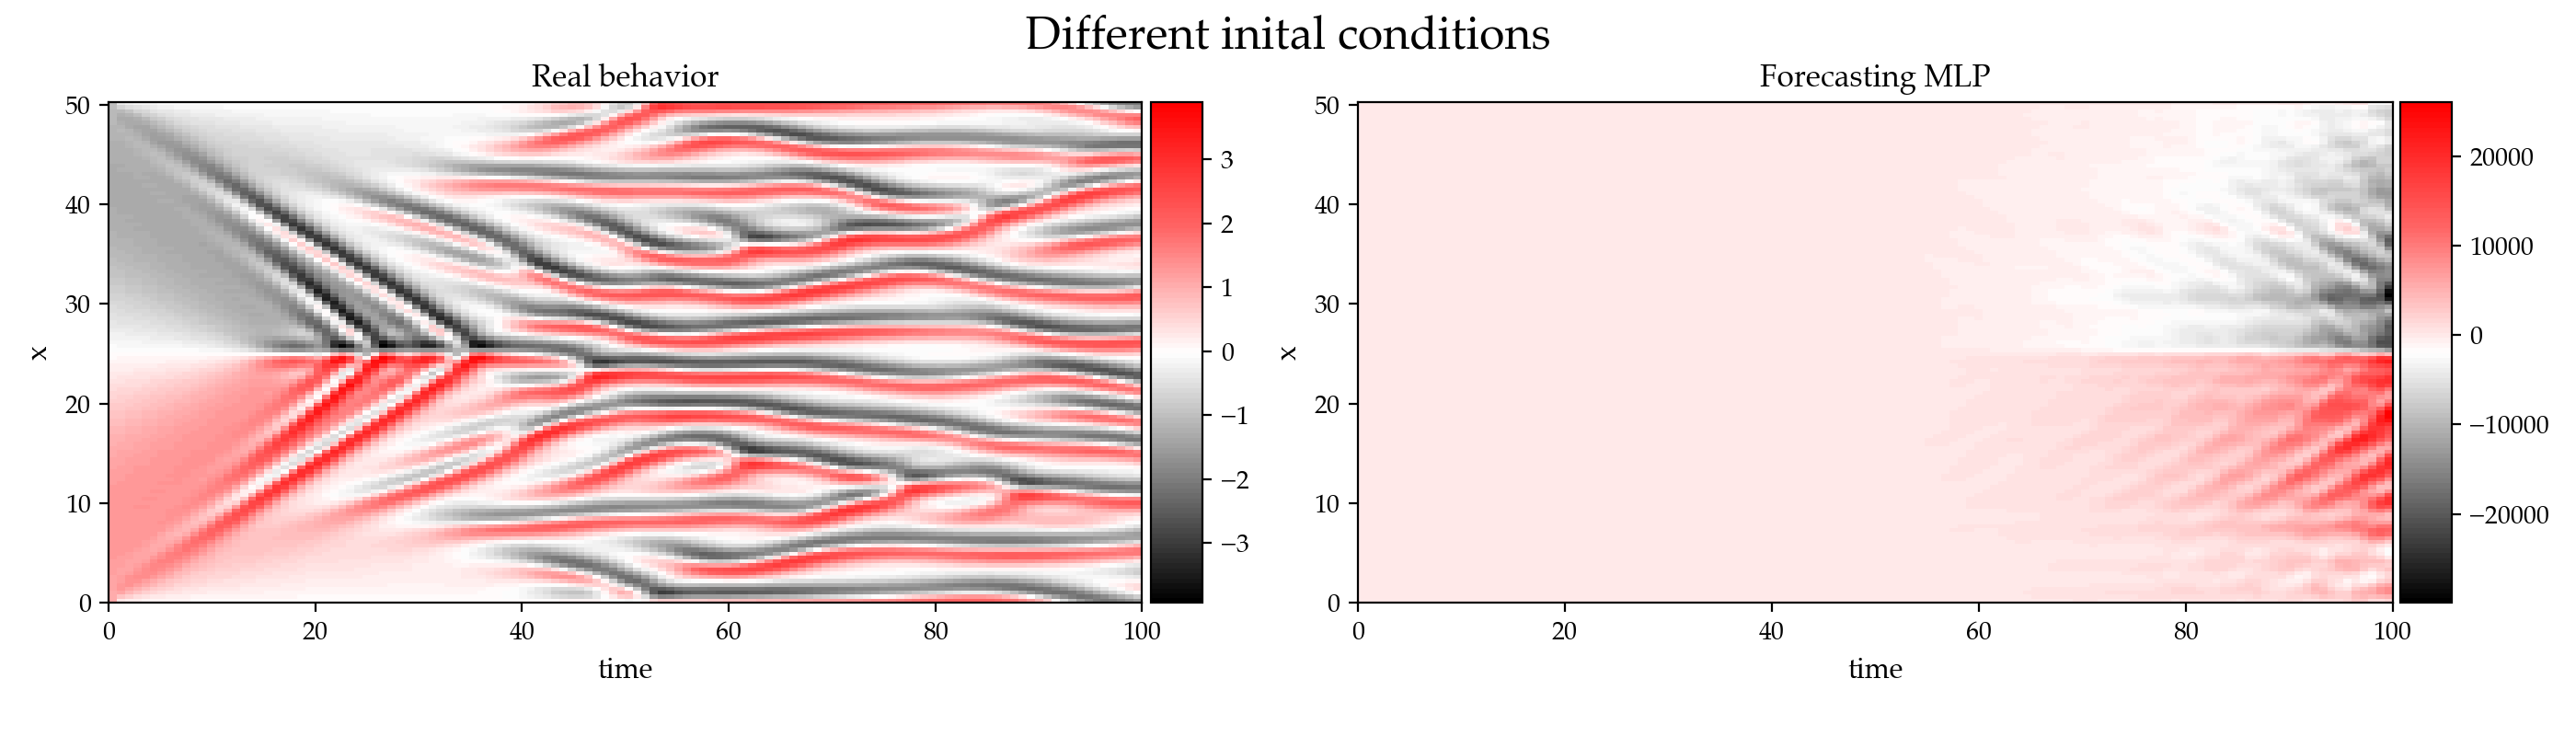

In [133]:
fig = plt.figure(figsize=(14, 4))
fig.suptitle("Different inital conditions", fontsize=18)

norm1 = mpl.colors.Normalize(vmin=np.min(u_f), vmax=np.max(u_f))
norm2 = mpl.colors.Normalize(vmin=np.min(u_frc), vmax=np.max(u_frc))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.imshow(u_f.T, interpolation='nearest', cmap=cm, norm=norm1,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Real behavior', fontsize = 12)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u_frc[:, :-1].T, interpolation='nearest', cmap=cm, norm=norm2, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP', fontsize = 12)

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/fore_diff_ic2.pdf', format='pdf', dpi=1200)

In [ ]:
class MLPNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out, prob):
        super(MLPNN, self).__init__()
        #layer 1
        self.h1 = torch.nn.Linear(D_in, H)
        torch.nn.init.xavier_uniform_(self.h1.weight)
        torch.nn.init.zeros_(self.h1.bias)
        self.drop1 = torch.nn.Dropout(p=prob)
        self.relu1 = torch.nn.ReLU()
        #layer 2
        self.h2 = torch.nn.Linear(H, H)
        torch.nn.init.xavier_uniform_(self.h2.weight)
        torch.nn.init.zeros_(self.h2.bias)
        self.drop2 = torch.nn.Dropout(p=prob)
        self.relu2 = torch.nn.ReLU()
        #layer 3
        self.h3 = torch.nn.Linear(H, H)
        torch.nn.init.xavier_uniform_(self.h3.weight)
        torch.nn.init.zeros_(self.h3.bias)
        self.drop3 = torch.nn.Dropout(p=prob)
        self.relu3 = torch.nn.ReLU()
        #output layer
        self.l_out = nn.Linear(H, D_out)
        torch.nn.init.xavier_uniform_(self.l_out.weight)
        torch.nn.init.zeros_(self.l_out.bias)

    def forward(self, x):
        x = self.h1(x)
        x = self.drop1(x)
        x = self.relu1(x)
        x = self.h2(x)
        x = self.drop2(x)
        x = self.relu2(x)
        x = self.h3(x)
        x = self.drop3(x)
        x = self.relu3(x)
        y_pred = self.l_out(x)
        return y_pred